# План семинара

1. Сравниваем PCA, SVD, ALS на примере случайной матрички
2. Знакомимся с датасетом статей
3. Смотрим на похожести item2item в статьях

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib inline

In [56]:
A = np.random.randn(8, 5)

In [57]:
np.cov(A).shape

(8, 8)

# PCA

In [58]:
def center_mass(a):
    return a.mean(axis=0)

def covariance(A):
    ma = center_mass(A)
    return (A - ma).T @ (A - ma)

In [59]:
assert covariance(A).shape == (A.shape[1], A.shape[1])
assert center_mass(A).shape == (A.shape[1],)
assert np.allclose(covariance(A), covariance(A).T)

In [60]:
def eig_values(Q):
    return linalg.eigh(Q, eigvals_only=True)

def eig_vectors(Q):
    return linalg.eigh(Q)[1]

In [61]:
Q = covariance(A)
D, V = eig_values(covariance(A)), eig_vectors(covariance(A))
assert D.shape == (A.shape[1],)
assert V.shape == (A.shape[1], A.shape[1])
assert np.allclose(np.sort(D), D)
assert np.allclose(V.T.dot(V), np.eye(A.shape[1]))
assert np.allclose(V.dot(V.T), np.eye(A.shape[1]))
assert np.allclose(np.trace(covariance(A)), D.sum())
assert np.allclose(V.dot(np.diag(D)).dot(V.T), Q)

Формула для pca: $A=U S V^T + {\rm center\space mass}$

$Q = (A-centA).T(A-centA) = VSU^T USV^T = VS^2V^T$

$D = S^2$

$V = V$

In [62]:
def pca_decomposition(A, k):
    MA = center_mass(A)
    Q = covariance(A - MA)
    D, V = eig_values(Q), eig_vectors(Q)
    S = np.sqrt(D)
    U = (A - MA) @ V @ np.diag(1 / S)

    num_to_take = A.shape[1] - k
    S = np.eye(k) * S[num_to_take:]
    V = V[:, num_to_take:]
    U = U[:, num_to_take:]
    return U, S, V, MA

def pca_recover(U, S, V, MA):
    return U @ S @ V.T + MA

In [63]:
k = 2
U, S, V, MA = pca_decomposition(A, k)
assert pca_recover(U, S, V, MA).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert MA.shape == (A.shape[1],)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(pca_recover(*pca_decomposition(A, A.shape[1])), A)

In [64]:
frobenius_norms = []
for k in range(0, 6):
    U, S, V, MA = pca_decomposition(A, k)
    AA = pca_recover(U, S, V, MA)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])
assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(covariance(A)))))


47.68 28.46 13.37 3.01 0.32 0.00


# SVD

Формула для svd: $A=U S V^T$

$Q = A.TA = VSU^T USV^T = VS^2V^T$

$D = S^2$

$V = V$

In [65]:
def svd_decomposition(A, k):
    Q = A.T @ A
    D, V = eig_values(Q), eig_vectors(Q)
    S = np.sqrt(D)
    U = A @ V @ np.diag(1 / S)
    num_to_take = A.shape[1] - k
    S = np.eye(k) * S[num_to_take:]
    V = V[:, num_to_take:]
    U = U[:, num_to_take:]
    return U, S, V

def svd_recover(U, S, V):
    return U @ S @ V.T

In [66]:
k = 2
U, S, V = svd_decomposition(A, k)
assert svd_recover(U, S, V).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(svd_recover(*svd_decomposition(A, A.shape[1])), A)

In [67]:
frobenius_norms = []
for k in range(0, 6):
    U, S, V = svd_decomposition(A, k)
    AA = svd_recover(U, S, V)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])
assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(A.T.dot(A)))))

51.62 31.92 15.40 3.70 0.40 0.00


# ALS

In [83]:
k = 2
lam = 1e-4

In [84]:
def calc_oposite_vectors(Y, A, lam: float):
    inter = Y.T @ Y + lam * np.eye(Y.shape[1])
    return A @ Y @ linalg.inv(inter).T

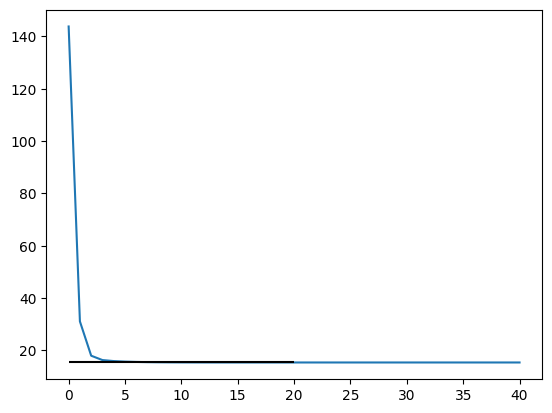

In [85]:
X, Y = np.random.randn(A.shape[0], k), np.random.randn(A.shape[1], k)
frobenius_norms = [np.sum((A - X.dot(Y.T))**2)]
steps = list(range(20))
for i in steps:
    X = calc_oposite_vectors(Y, A, lam)
    frobenius_norms.append(np.sum((A - X.dot(Y.T))**2))
    Y = calc_oposite_vectors(X, A.T, lam)
    frobenius_norms.append(np.sum((A - X.dot(Y.T))**2))
plt.plot(frobenius_norms)
plt.hlines(np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1], 0, 20, color='black')

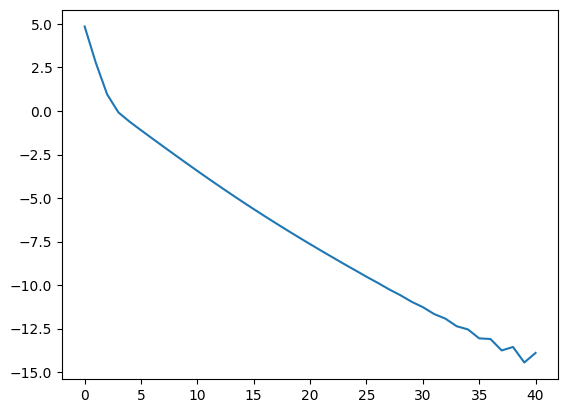

In [86]:
plt.plot(np.log(frobenius_norms-np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1]))

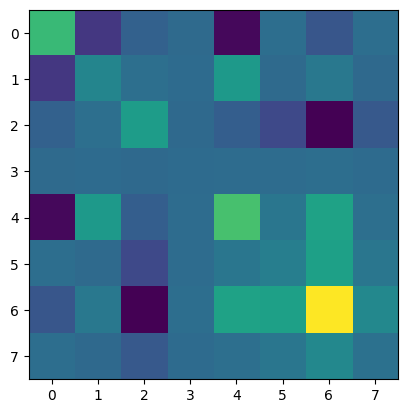

In [72]:
plt.imshow(X.dot(X.T))

In [87]:
X.T.dot(X)

array([[ 0.87429219, -0.43404643],
       [-0.43404643,  1.43039449]])

In [88]:
AA_svd = svd_recover(*svd_decomposition(A, k))
AA_als = X.dot(Y.T)
assert np.allclose(AA_svd, AA_als, rtol=1e-3, atol=1e-3)